In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import seaborn as sns
import numpy as np

import torch
from torch.utils.data import DataLoader

from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import binned_statistic

import matplotlib.pyplot as plt

from code.tabular import TabularDataset
from code.normal import DeepNormal, DeepMultivariateNormal

In [3]:
sns.set(palette='colorblind', font_scale=1.3)
palette = sns.color_palette()

In [4]:
seed = 456
np.random.seed(seed);
torch.manual_seed(seed);

# Training

In [71]:
def compute_loss(model, x, y):
    normal = model(x)
    nll = -normal.log_prob(y)
    return torch.mean(nll)

def compute_rmse(model, x, y):
    y_hat = model(x).mean
    return torch.sqrt(torch.mean((y_hat - y)**2))

In [94]:
def train_one_step(model, optimizer, x, y):
    optimizer.zero_grad()
    loss = compute_loss(model, x, y)
    loss.backward()
    optimizer.step()
    return loss

def train(model, optimizer, train_dataset, test_dataset, n_epochs, batch_size=128, scheduler=None, print_every=10):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    test_x, test_y = test_dataset.data.to(device), test_dataset.labels.to(device)
    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    
    train_losses, test_losses = [], []
    for epoch in range(n_epochs):
        
        train_losses_batch, test_losses_batch, test_rmse_batch = [], [], []
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            model.train()
            train_loss = train_one_step(model, optimizer, x_batch, y_batch)

            model.eval()
            test_loss = compute_loss(model, test_x, test_y)
            test_rmse = compute_rmse(model, test_x, test_y)

            train_losses_batch.append(train_loss.cpu().detach().numpy())
            test_losses_batch.append(test_loss.cpu().detach().numpy())
            test_rmse_batch.append(test_rmse.cpu().detach().numpy())
            
        if scheduler is not None:
            scheduler.step()
            
        train_loss_mean = np.mean(train_losses_batch)
        test_loss_mean = np.mean(test_losses_batch)
        test_rmse_mean = np.mean(test_rmse_batch)
        
        train_losses.append(train_loss_mean)
        test_losses.append(test_loss_mean)

        if epoch == 0 or (epoch + 1) % print_every == 0:
            print(
                f'Epoch {epoch+1} | Train Loss = {train_loss_mean:.4f} | '
                f'Test loss = {test_loss_mean:.4f} | Test RMSE = {test_rmse_mean:.4f}'
            )
        
    _, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(range(1, n_epochs + 1), train_losses, label='Train loss')
    ax.plot(range(1, n_epochs + 1), test_losses, label='Test loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training Overview')
    ax.legend()
    
    return train_losses, test_losses

# Single-task Regression

This sections demonstrates parameterizing a distribution with a neural network as a means of uncertainty quantification.

We consider the [OLS Regression Challenge](https://data.world/nrippner/ols-regression-challenge) which aims to predict cancer death rates given a range of socioeconomic factors. 

Example: https://romainstrock.com/blog/modeling-uncertainty-with-pytorch.html

**Data Dictionary**
- TARGET_deathRate: Dependent variable. Mean per capita (100,000) cancer mortalities (a)
- avgAnnCount: Mean number of reported cases of cancer diagnosed annually (a)
- avgDeathsPerYear: Mean number of reported mortalities due to cancer (a)
- incidenceRate: Mean per capita (100,000) cancer diagoses (a)
- medianIncome: Median income per county (b)
- popEst2015: Population of county (b)
- povertyPercent: Percent of populace in poverty (b)
- studyPerCap: Per capita number of cancer-related clinical trials per county (a)
- binnedInc: Median income per capita binned by decile (b)
- MedianAge: Median age of county residents (b)
- MedianAgeMale: Median age of male county residents (b)
- MedianAgeFemale: Median age of female county residents (b)
- Geography: County name (b)
- AvgHouseholdSize: Mean household size of county (b)
- PercentMarried: Percent of county residents who are married (b)
- PctNoHS18_24: Percent of county residents ages 18-24 highest education attained: less than high school (b)
- PctHS18_24: Percent of county residents ages 18-24 highest education attained: high school diploma (b)
- PctSomeCol18_24: Percent of county residents ages 18-24 highest education attained: some college (b)
- PctBachDeg18_24: Percent of county residents ages 18-24 highest education attained: bachelor's degree (b)
- PctHS25_Over: Percent of county residents ages 25 and over highest education attained: high school diploma (b)
- PctBachDeg25_Over: Percent of county residents ages 25 and over highest education attained: bachelor's degree (b)
- PctEmployed16_Over: Percent of county residents ages 16 and over employed (b)
- PctUnemployed16_Over: Percent of county residents ages 16 and over unemployed (b)
- PctPrivateCoverage: Percent of county residents with private health coverage (b)
- PctPrivateCoverageAlone: Percent of county residents with private health coverage alone (no public assistance) (b)
- PctEmpPrivCoverage: Percent of county residents with employee-provided private health coverage (b)
- PctPublicCoverage: Percent of county residents with government-provided health coverage (b)
- PctPubliceCoverageAlone: Percent of county residents with government-provided health coverage alone (b)
- PctWhite: Percent of county residents who identify as White (b)
- PctBlack: Percent of county residents who identify as Black (b)
- PctAsian: Percent of county residents who identify as Asian (b)
- PctOtherRace: Percent of county residents who identify in a category which is not White, Black, or Asian (b)
- PctMarriedHouseholds: Percent of married households (b)
- BirthRate: Number of live births relative to number of women in county (b)

 to nuer of women in county (b)
Notes:

(a): years 2010-2016
(b): 2013 Census Estimates

## Dataset

In [5]:
df = pd.read_csv(os.path.join("data", "cancer_reg.csv"))
df.head()

,avgAnnCount,avgDeathsPerYear,TARGET_deathRate,incidenceRate,medIncome,popEst2015,povertyPercent,studyPerCap,binnedInc,MedianAge,...,PctPrivateCoverageAlone,PctEmpPrivCoverage,PctPublicCoverage,PctPublicCoverageAlone,PctWhite,PctBlack,PctAsian,PctOtherRace,PctMarriedHouseholds,BirthRate
0,1397.0,469,164.9,489.8,61898,260131,11.2,499.748204,"(61494.5, 125635]",39.3,...,NaN,41.6,32.9,14.0,81.780529,2.594728,4.821857,1.843479,52.856076,6.118831
1,173.0,70,161.3,411.6,48127,43269,18.6,23.111234,"(48021.6, 51046.4]",33.0,...,53.8,43.6,31.1,15.3,89.228509,0.969102,2.246233,3.741352,45.372500,4.333096
2,102.0,50,174.7,349.7,49348,21026,14.6,47.560164,"(48021.6, 51046.4]",45.0,...,43.5,34.9,42.1,21.1,90.922190,0.739673,0.465898,2.747358,54.444868,3.729488
3,427.0,202,194.8,430.4,44243,75882,17.1,342.637253,"(42724.4, 45201]",42.8,...,40.3,35.0,45.3,25.0,91.744686,0.782626,1.161359,1.362643,51.021514,4.603841
4,57.0,26,144.4,350.1,49955,10321,12.5,0.000000,"(48021.6, 51046.4]",48.3,...,43.9,35.1,44.0,22.7,94.104024,0.270192,0.665830,0.492135,54.027460,6.796657


In [6]:
df.describe()

,avgAnnCount,avgDeathsPerYear,TARGET_deathRate,incidenceRate,medIncome,popEst2015,povertyPercent,studyPerCap,MedianAge,MedianAgeMale,...,PctPrivateCoverageAlone,PctEmpPrivCoverage,PctPublicCoverage,PctPublicCoverageAlone,PctWhite,PctBlack,PctAsian,PctOtherRace,PctMarriedHouseholds,BirthRate
count,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000,3.047000e+03,3047.000000,3047.000000,3047.000000,3047.000000,...,2438.000000,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000
mean,606.338544,185.965868,178.664063,448.268586,47063.281917,1.026374e+05,16.878175,155.399415,45.272333,39.570725,...,48.453774,41.196324,36.252642,19.240072,83.645286,9.107978,1.253965,1.983523,51.243872,5.640306
std,1416.356223,504.134286,27.751511,54.560733,12040.090836,3.290592e+05,6.409087,529.628366,45.304480,5.226017,...,10.083006,9.447687,7.841741,6.113041,16.380025,14.534538,2.610276,3.517710,6.572814,1.985816
min,6.000000,3.000000,59.700000,201.300000,22640.000000,8.270000e+02,3.200000,0.000000,22.300000,22.400000,...,15.700000,13.500000,11.200000,2.600000,10.199155,0.000000,0.000000,0.000000,22.992490,0.000000
25%,76.000000,28.000000,161.200000,420.300000,38882.500000,1.168400e+04,12.150000,0.000000,37.700000,36.350000,...,41.000000,34.500000,30.900000,14.850000,77.296180,0.620675,0.254199,0.295172,47.763063,4.521419
50%,171.000000,61.000000,178.100000,453.549422,45207.000000,2.664300e+04,15.900000,0.000000,41.000000,39.600000,...,48.700000,41.100000,36.300000,18.800000,90.059774,2.247576,0.549812,0.826185,51.669941,5.381478
75%,518.000000,149.000000,195.200000,480.850000,52492.000000,6.867100e+04,20.400000,83.650776,44.000000,42.500000,...,55.600000,47.700000,41.550000,23.100000,95.451693,10.509732,1.221037,2.177960,55.395132,6.493677
max,38150.000000,14010.000000,362.800000,1206.900000,125635.000000,1.017029e+07,47.400000,9762.308998,624.000000,64.700000,...,78.900000,70.700000,65.100000,46.600000,100.000000,85.947799,42.619425,41.930251,78.075397,21.326165


### Distribution of learning target

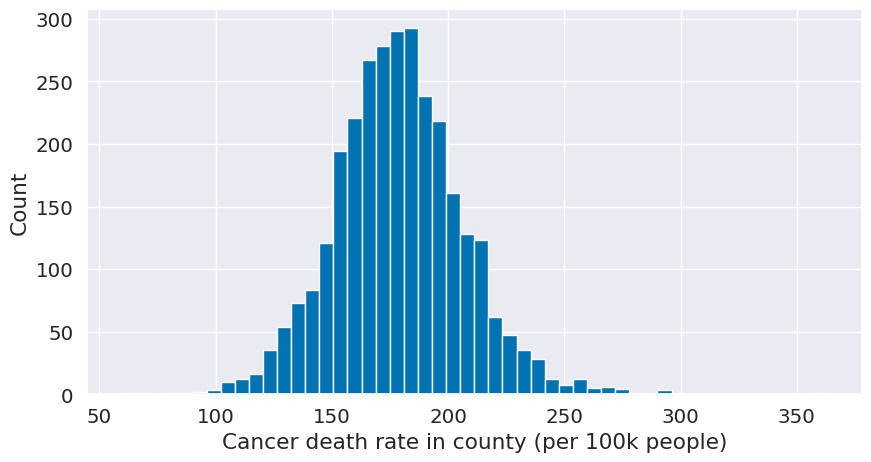

In [7]:
_, ax = plt.subplots(1, 1, figsize=(10, 5))
df['TARGET_deathRate'].hist(bins=50, ax=ax);
ax.set_xlabel('Cancer death rate in county (per 100k people)');
ax.set_ylabel('Count');

### Pre-process data

In [8]:
target = 'TARGET_deathRate'
unwanted_features = [
        target, 
        'Geography',                # Label describing the county - each row has a different one
        'binnedInc',                # Redundant with median income?
        'PctSomeCol18_24',          # contains null values - ignoring for now
        'PctEmployed16_Over',       # contains null values - ignoring for now
        'PctPrivateCoverageAlone',  # contains null values - ignoring for now
    ]
features = [col for col in df.columns if col not in unwanted_features]
print(len(features), 'features')

28 features


In [9]:
x = df[features].values
y = df[[target]].values

x.shape, y.shape

((3047, 28), (3047, 1))

In [124]:
input_scaler = StandardScaler()
output_scaler = StandardScaler()
x_scaled = input_scaler.fit_transform(x)
y_scaled = output_scaler.fit_transform(y)

In [125]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size=0.2)

x_train = torch.from_numpy(x_train).float()
x_test = torch.from_numpy(x_test).float()
y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()

x_train.shape[0], x_test.shape[0]

(2437, 610)

In [126]:
train_dataset = TabularDataset(x_train, y_train)
test_dataset = TabularDataset(x_test, y_test)

## Training

In [182]:
model = DeepNormal(input_size=x.shape[1], hidden_size=100)

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{pytorch_total_params:,} trainable parameters')

model

21,502 trainable parameters


DeepNormal(
  (embedding): Sequential(
    (0): Linear(in_features=10, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (mean): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=100, out_features=1, bias=True)
  )
  (std): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=100, out_features=1, bias=True)
    (4): Softplus(beta=1, threshold=20)
  )
)

Epoch 1 | Train Loss = 1.4430 | Test loss = 1.2891 | Test RMSE = 0.8839
Epoch 10 | Train Loss = 1.2002 | Test loss = 1.1185 | Test RMSE = 0.7510
Epoch 20 | Train Loss = 1.0481 | Test loss = 0.9475 | Test RMSE = 0.6615
Epoch 30 | Train Loss = 0.9970 | Test loss = 0.9196 | Test RMSE = 0.6488
Epoch 40 | Train Loss = 0.9710 | Test loss = 0.9038 | Test RMSE = 0.6433
Epoch 50 | Train Loss = 0.9481 | Test loss = 0.8962 | Test RMSE = 0.6402
Epoch 60 | Train Loss = 0.9382 | Test loss = 0.8858 | Test RMSE = 0.6348
Epoch 70 | Train Loss = 0.9274 | Test loss = 0.8803 | Test RMSE = 0.6335
Epoch 80 | Train Loss = 0.9049 | Test loss = 0.8786 | Test RMSE = 0.6326
Epoch 90 | Train Loss = 0.8921 | Test loss = 0.8741 | Test RMSE = 0.6296
Epoch 100 | Train Loss = 0.8942 | Test loss = 0.8749 | Test RMSE = 0.6309
Epoch 110 | Train Loss = 0.8643 | Test loss = 0.8728 | Test RMSE = 0.6268
Epoch 120 | Train Loss = 0.8558 | Test loss = 0.8690 | Test RMSE = 0.6236
Epoch 130 | Train Loss = 0.8476 | Test loss = 0.8

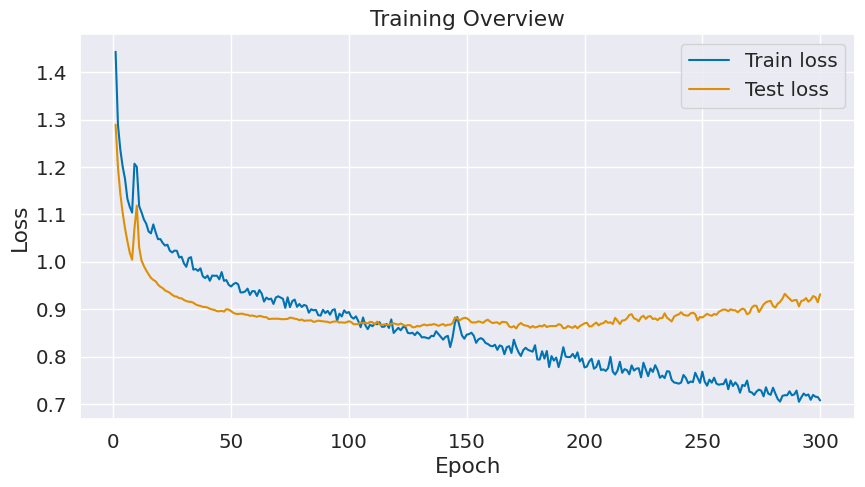

In [178]:
learning_rate = 1e-3
momentum = 0.9
weight_decay = 1e-5

optimizer = torch.optim.SGD(
    model.parameters(), 
    lr=learning_rate, 
    momentum=momentum, 
    nesterov=True,
    weight_decay=weight_decay,
)

n_epochs = 300
batch_size = 64
print_every = 10

train_losses, test_losses = train(
    model, 
    optimizer, 
    train_dataset,
    test_dataset,
    n_epochs=n_epochs, 
    batch_size=batch_size,
    print_every=print_every,
)

## Validation

In [179]:
model = model.to("cpu")

In [180]:
y_dist = model(x_test)
y_hat = y_dist.mean

In [181]:
test_rmse = float(compute_rmse(model, x_test, y_test).detach().numpy())
print(f'Test RMSE = {test_rmse:.2f}')

Test RMSE = 0.63


In [182]:
test_r2 = r2_score(y_test, y_hat.detach().numpy().flatten())
print(f'Test R^2 = {test_r2:.2f}')

Test R^2 = 0.55


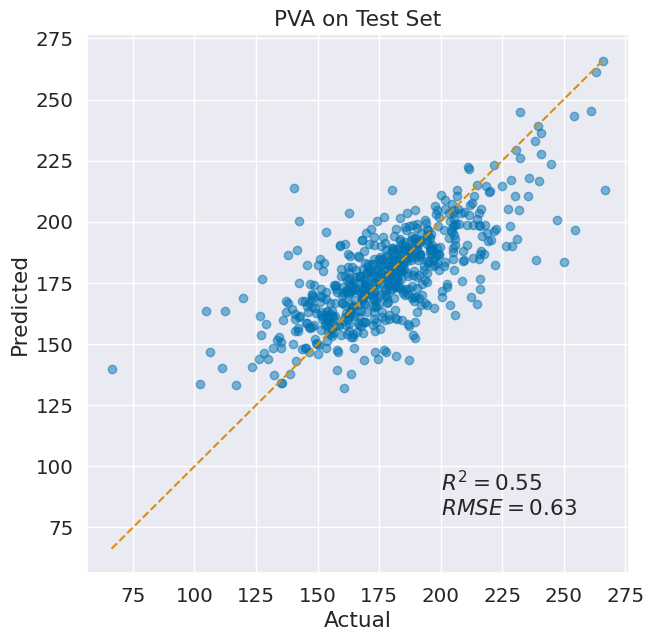

In [183]:
def plot_pva(y_true, y_pred):
    f, ax = plt.subplots(1, 1, figsize=(7, 7))
    palette = sns.color_palette()
    
    min_value = min(np.amin(y_true), np.amin(y_pred))
    max_value = max(np.amax(y_true), np.amax(y_pred))
    y_mid = np.linspace(min_value, max_value)
    
    ax.plot(y_mid, y_mid, '--', color=palette[1])
    ax.scatter(y_true, y_pred, color=palette[0], alpha=0.5);
    
    return f, ax

y_test_unscaled = output_scaler.inverse_transform(y_test.detach().numpy())
y_hat_unscaled = output_scaler.inverse_transform(y_hat.detach().numpy())

f, ax = plot_pva(
    y_test_unscaled.flatten(),
    y_hat_unscaled.flatten(),
);

ax.text(200, 90, f'$R^2 = {test_r2:.2f}$')
ax.text(200, 80, f'$RMSE = {test_rmse:.2f}$')
    
ax.set_xlabel('Actual');
ax.set_ylabel('Predicted');
ax.set_title('PVA on Test Set');

## Uncertainty

In [184]:
def make_predictions(model, x):
    dist = model(x)
    mean = dist.mean.detach().numpy()
    std = dist.stddev.detach().numpy()
    
    mean = output_scaler.inverse_transform(mean)
    std = std * output_scaler.scale_
    
    return mean, std

In [185]:
y_hat, std = make_predictions(model, x_test)

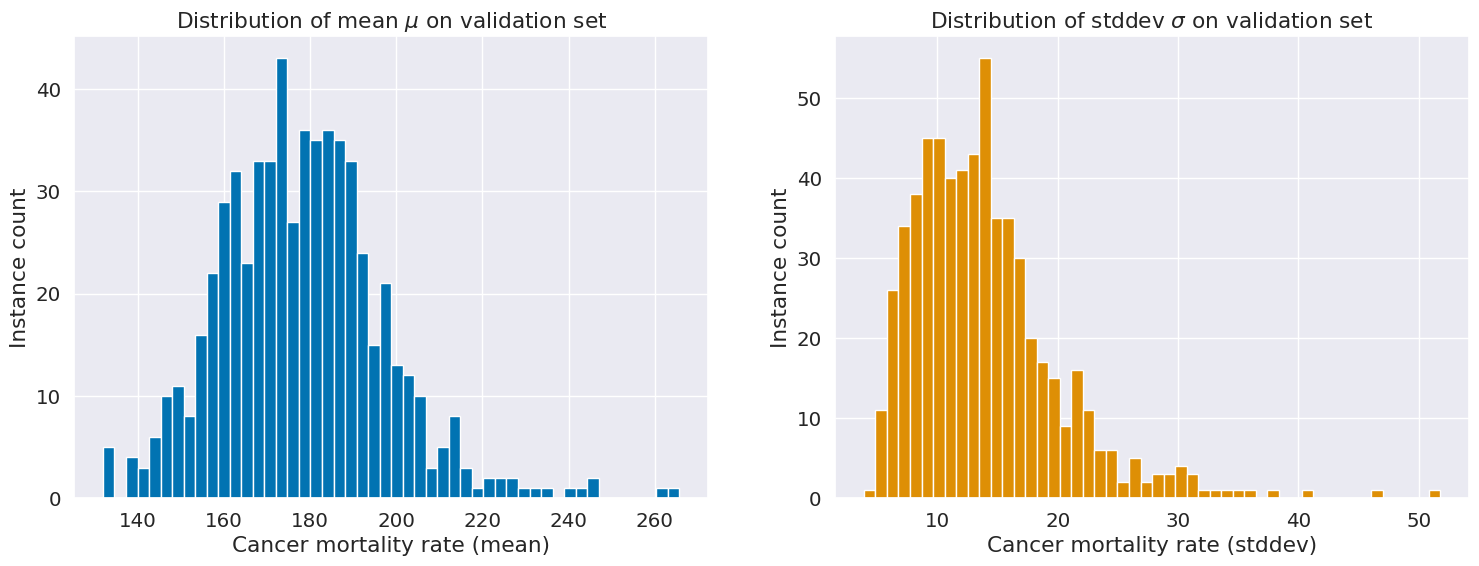

In [186]:
f, axes = plt.subplots(1, 2, figsize=(18, 6))
ax1, ax2 = axes

ax1.hist(y_hat.flatten(), bins=50);
ax2.hist(std.flatten(), bins=50, color=palette[1]);

ax1.set_xlabel('Cancer mortality rate (mean)');
ax1.set_ylabel('Instance count');
ax1.set_title('Distribution of mean $\mu$ on validation set');

ax2.set_xlabel('Cancer mortality rate (stddev)');
ax2.set_ylabel('Instance count');
ax2.set_title('Distribution of stddev $\sigma$ on validation set');

In [187]:
low_ix = [i for i, v in enumerate(y_hat.flatten()) if float(v) < 140][0]
average_ix = [i for i, v in enumerate(y_hat.flatten()) if 170 < float(v) < 190][0]
high_ix = [i for i, v in enumerate(y_hat.flatten()) if float(v) > 220][0]

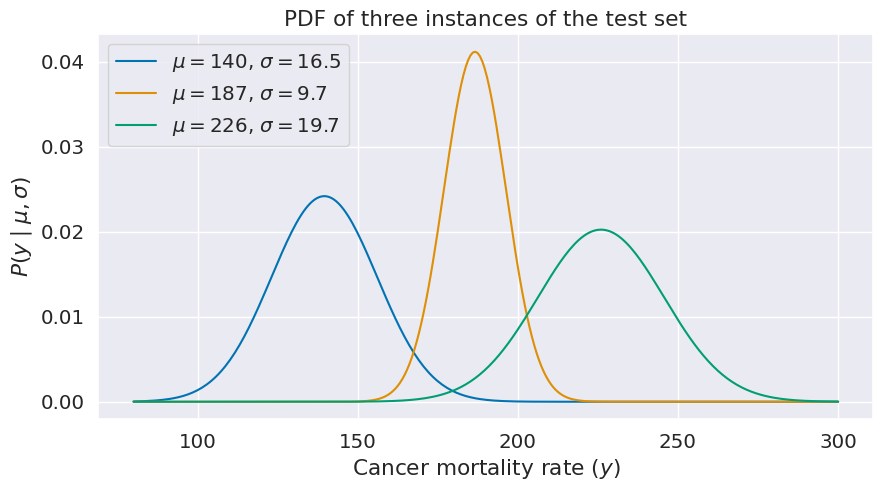

In [188]:
def plot_normal_distributions(y_hat, std, indices):
    f, ax = plt.subplots(1, 1, figsize=(10, 5))
    
    normal_fn = lambda z, m, s: (1/(s * np.sqrt(2*np.pi))) * np.exp(-0.5*((z - m) / s)**2)
    
    x = np.linspace(80, 300, 300)
    
    for ix in indices:
        mu = y_hat.flatten()[ix]
        sigma = std.flatten()[ix]
        
        ax.plot(x, normal_fn(x, mu, sigma), label=rf'$\mu = {mu:.0f}$, $\sigma = {sigma:.1f}$')
    
    ax.set_xlabel('Cancer mortality rate ($y$)');
    ax.set_ylabel(r'$P(y \mid \mu, \sigma)$');
    ax.set_title('PDF of three instances of the test set');
    ax.legend(loc='upper left');
    
    return f, ax

f, ax = plot_normal_distributions(y_hat, std, [low_ix, average_ix, high_ix])

# Local Covariance

## Data Generation

In [150]:
def rosenbrock(x):
    return torch.diff(x, axis=1).sum(axis=1) + (x - 1).sum(axis=1)

def multitask_objective(x, period=0.5, noise=0.0):
    y1 = rosenbrock(x)
    y2 = torch.sin(period * y1) + noise * torch.randn(y1.shape)
    return torch.stack([y1, y2], axis=1)

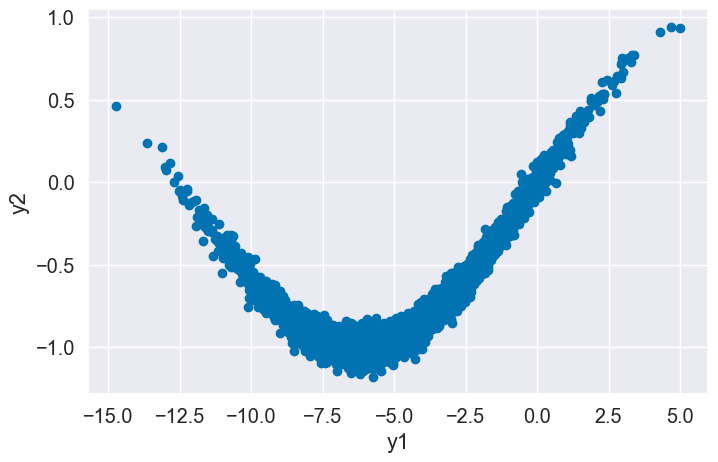

In [155]:
n = 5000
input_size = 5

x = torch.randn(n, input_size)
y = multitask_objective(x, noise=0.05, period=0.25)

fig, ax = plt.subplots(1, figsize=(8, 5))
ax.scatter(y[:,0], y[:,1])

ax.set_xlabel("y1")
ax.set_ylabel("y2")

plt.show()

In [156]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

x_train.shape, x_test.shape

(torch.Size([4000, 5]), torch.Size([1000, 5]))

In [157]:
train_dataset = TabularDataset(x_train, y_train)
test_dataset = TabularDataset(x_test, y_test)

## Training

In [171]:
input_size = x_train.shape[1]
label_size = y_train.shape[1]
hidden_size = 64

model = DeepMultivariateNormal(input_size=input_size, hidden_size=hidden_size, label_size=label_size)

learning_rate = 1e-2
momentum = 0.9
weight_decay = 1e-5

optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=learning_rate, 
    weight_decay=weight_decay,
)

model

DeepMultivariateNormal(
  (embedding): Sequential(
    (0): Linear(in_features=5, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
  )
  (mean): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=2, bias=True)
  )
  (variance): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=2, bias=True)
    (4): Softplus(beta=1, threshold=20)
  )
  (correlation): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)

Epoch 1 | Train Loss = 37.5427 | Test loss = 26.7983 | Test RMSE = 3.8816
Epoch 100 | Train Loss = 0.6991 | Test loss = 0.1767 | Test RMSE = 0.3659
Epoch 200 | Train Loss = -0.1972 | Test loss = -0.8668 | Test RMSE = 0.1826
Epoch 300 | Train Loss = -0.3845 | Test loss = -0.9765 | Test RMSE = 0.1532
Epoch 400 | Train Loss = -0.5044 | Test loss = -1.1001 | Test RMSE = 0.1343
Epoch 500 | Train Loss = -0.5531 | Test loss = -1.1353 | Test RMSE = 0.1419
Epoch 600 | Train Loss = -0.6430 | Test loss = -1.1946 | Test RMSE = 0.1223
Epoch 700 | Train Loss = -0.7469 | Test loss = -1.2799 | Test RMSE = 0.1582
Epoch 800 | Train Loss = -0.8195 | Test loss = -1.3317 | Test RMSE = 0.1719
Epoch 900 | Train Loss = -0.8885 | Test loss = -1.4509 | Test RMSE = 0.1313
Epoch 1000 | Train Loss = -0.9584 | Test loss = -1.4958 | Test RMSE = 0.1317


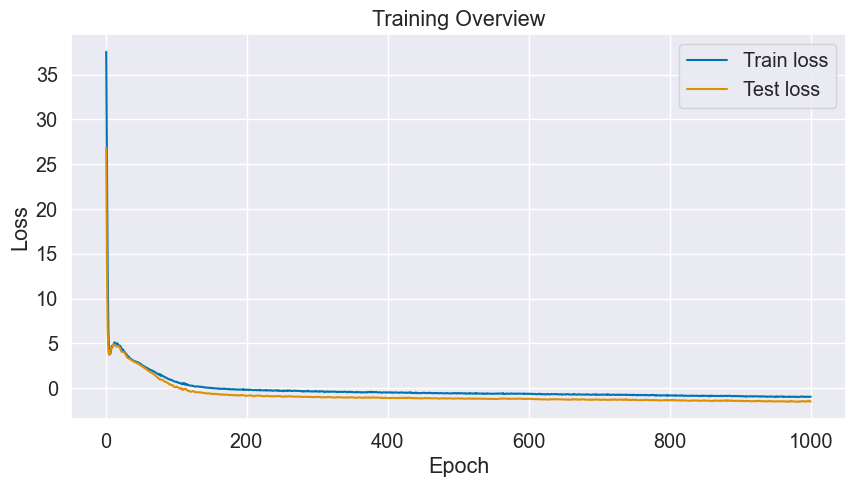

In [172]:
n_epochs = 1000
batch_size=x_train.shape[0]
print_every = 100

train_losses, test_losses = train(
    model, 
    optimizer, 
    train_dataset,
    test_dataset,
    n_epochs=n_epochs, 
    batch_size=batch_size,
    print_every=print_every,
)

## Visualization

In [173]:
model = model.cpu()
model.eval()

mvn_pred = model(x_test)
mean_pred = mvn_pred.mean.detach().numpy()
cov_pred = mvn_pred.covariance_matrix.detach().numpy()

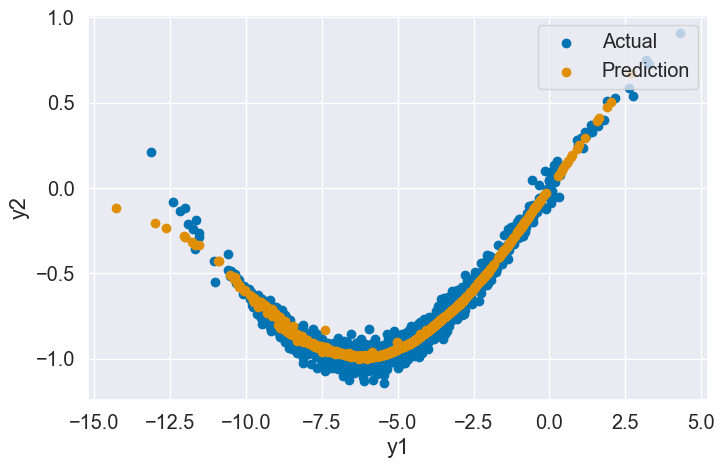

In [174]:
fig, ax = plt.subplots(1, figsize=(8, 5))

ax.scatter(y_test[:,0], y_test[:,1], label="Actual")
ax.scatter(mean_pred[:,0], mean_pred[:,1], label="Prediction")

ax.set_xlabel("y1")
ax.set_ylabel("y2")
ax.legend(loc="upper right")

plt.show()

Plot dependence of cross-label covariance on label value to check internal consistency:

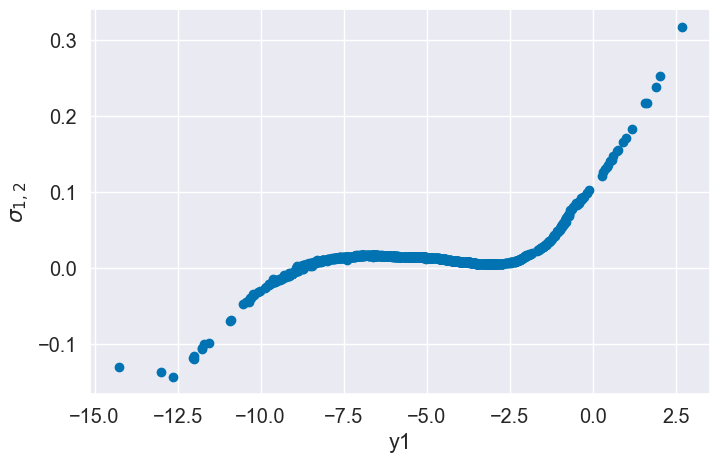

In [175]:
fig, ax = plt.subplots(1, figsize=(8, 5))

ax.scatter(mean_pred[:,0], cov_pred[:,1,0])

ax.set_xlabel("y1")
ax.set_ylabel("$\sigma_{1,2}$")

plt.show()